In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import os
import torch.nn as nn
import torch.optim as optim

In [2]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.preprocessed_data = None
        self.features = None
        self.labels = None
    
    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)
            print(f"Data loaded successfully with shape {self.data.shape}")
        except FileNotFoundError:
            print(f"File {self.file_path} not found!")
            raise
    
    def preprocess_data(self, target_column, categorical_columns=None, numerical_columns=None):
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")

        # Separate features and labels
        self.features = self.data.drop(columns=[target_column])
        self.labels = self.data[target_column]

        # Impute missing values
        if categorical_columns:
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            self.features[categorical_columns] = categorical_imputer.fit_transform(self.features[categorical_columns])

        if numerical_columns:
            numerical_imputer = SimpleImputer(strategy='mean')
            self.features[numerical_columns] = numerical_imputer.fit_transform(self.features[numerical_columns])

        # One-hot encode categorical features
        if categorical_columns:
            encoder = OneHotEncoder(sparse=False, drop='first')
            categorical_data = encoder.fit_transform(self.features[categorical_columns])
            categorical_columns_encoded = encoder.get_feature_names_out(categorical_columns)
            categorical_df = pd.DataFrame(categorical_data, columns=categorical_columns_encoded)
            self.features = self.features.drop(columns=categorical_columns)
            self.features = pd.concat([self.features.reset_index(drop=True), categorical_df], axis=1)

        # Normalize numerical features
        if numerical_columns:
            scaler = StandardScaler()
            self.features[numerical_columns] = scaler.fit_transform(self.features[numerical_columns])

        self.preprocessed_data = pd.concat([self.features, self.labels], axis=1)
        print("Preprocessing complete.")

    def generate_spikes(self):
        if self.preprocessed_data is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
    
        # Separate numerical and categorical columns
        numerical_data = self.features.select_dtypes(include=['float64', 'int64'])
        categorical_data = self.features.select_dtypes(exclude=['float64', 'int64'])

        # Generate spikes for numerical columns based on the median
        numerical_median = numerical_data.median()
        numerical_spike_train = np.where(numerical_data > numerical_median, 1, 0)
    
        # For categorical data, assuming it's already one-hot encoded or binary
        categorical_spike_train = categorical_data.values

        # Concatenate the numerical and categorical spikes
        spike_train = np.concatenate((numerical_spike_train, categorical_spike_train), axis=1)

        print("Spike generation complete.")
        return spike_train


    def get_train_test_split(self, test_size=0.2, random_state=42):
        if self.preprocessed_data is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        X = self.features
        y = self.labels
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Train-test split complete. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        return X_train, X_test, y_train, y_test

In [39]:
file_path = "autism_screening.csv"
categorical_columns = ['gender', 'ethnicity', 'jundice', 'austim', 'relation','contry_of_res','used_app_before','age_desc','relation']
numerical_columns = ['age','result', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 
                     'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

In [4]:
preprocessor = DataPreprocessor(file_path)
preprocessor.load_data()
preprocessor.preprocess_data(target_column='Class/ASD', categorical_columns=categorical_columns, numerical_columns=numerical_columns)
spike_train = preprocessor.generate_spikes()

print(spike_train[:10])

Data loaded successfully with shape (704, 21)
Preprocessing complete.
Spike generation complete.
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


C:\Users\vaish\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
import torch
import torch.nn as nn

class SpikeNeuronLayer(nn.Module):
    def __init__(self, input_size, output_size, threshold=1.0, decay=0.9):
        super(SpikeNeuronLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.threshold = threshold
        self.decay = decay
        
        self.weights = nn.Parameter(torch.rand(input_size, output_size))
        self.membrane_potential = torch.zeros(output_size)

    def forward(self, input_spikes):
        synaptic_input = torch.matmul(input_spikes, self.weights)
        self.membrane_potential = self.decay * self.membrane_potential + synaptic_input
        
        output_spikes = (self.membrane_potential >= self.threshold).float()l
        self.membrane_potential *= (1 - output_spikes)

        return output_spikes

In [6]:

class SpikeNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, threshold=1.0, decay=0.9):
        super(SpikeNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SpikeNeuronLayer(input_size, hidden_size, threshold, decay))
        for _ in range(num_layers - 1):
            self.layers.append(SpikeNeuronLayer(hidden_size, hidden_size, threshold, decay))
        self.output_layer = SpikeNeuronLayer(hidden_size, output_size, threshold, decay)

    def forward(self, input_spikes):
        x = input_spikes
        for layer in self.layers:
            x = layer(x)
        output_spikes = self.output_layer(x)
        return output_spikes

In [7]:
input_size = spike_train.shape[1]  # Number of input features from spike train
hidden_size = 64  
output_size = 2   # Binary classification: YES/NO (Class/ASD)
num_layers = 3 

In [8]:
spike_network = SpikeNetwork(input_size, hidden_size, output_size, num_layers)

In [57]:
input_spikes = torch.tensor(spike_train[:10], dtype=torch.float32)

In [58]:
# Forward pass through the spiking network
output_spikes = spike_network(input_spikes)
print(f"Output spikes from SNN: {output_spikes}")

Output spikes from SNN: tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


In [33]:
print(spike_train.shape)

(704, 103)


# DeepNetwork

In [17]:
class DeepNetwork(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=1, num_layers=3):
        super(DeepNetwork, self).__init__()
        
        layers = []
        in_dim = input_size
        
        # Create hidden layers based on num_layers and hidden_size
        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_size))
            in_dim = hidden_size

        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(in_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        output = self.output_layer(x)
        return output

input_size_dnn = 2 
hidden_size_dnn = 64  # Number of neurons per hidden layer
output_size_dnn = 1  # Output size of the network
num_layers_dnn = 3  #hidden layers

deep_network = DeepNetwork(input_size_dnn, hidden_size_dnn, output_size_dnn, num_layers_dnn)


In [13]:
class ReinforcementLearningModuleForDNN:
    def __init__(self, deep_network, learning_rate=0.001, gamma=0.99):
        self.deep_network = deep_network
        self.optimizer = optim.Adam(deep_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.critic = nn.Linear(deep_network.output_layer.out_features, 1)

    def compute_loss(self, predicted_output, reward):
        critic_value = self.critic(predicted_output)
        td_error = reward - critic_value
        return torch.mean(td_error ** 2)

    def update_policy(self, input_features, reward):
        predicted_output = self.deep_network(input_features)
        loss = self.compute_loss(predicted_output, reward)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [14]:
input_size_dnn = hidden_size  # Matches output from SNN
hidden_size_dnn = 128  
output_size_dnn = 2  
num_layers_dnn = 3  

In [23]:
deep_network = DeepNetwork(input_size_dnn, hidden_size_dnn, output_size_dnn, num_layers_dnn)
rl_module_dnn = ReinforcementLearningModuleForDNN(deep_network)

In [24]:
output_dnn = deep_network(output_spikes)
print(f"Deep Network output: {output_dnn}")

Deep Network output: tensor([[0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821],
        [0.0821]], grad_fn=<AddmmBackward0>)


In [25]:
reward_dnn = torch.tensor([1.0])

# Update DNN policy
loss_dnn = rl_module_dnn.update_policy(output_spikes, reward_dnn)
print(f"Loss after policy update: {loss_dnn}")

Loss after policy update: 0.06535892933607101


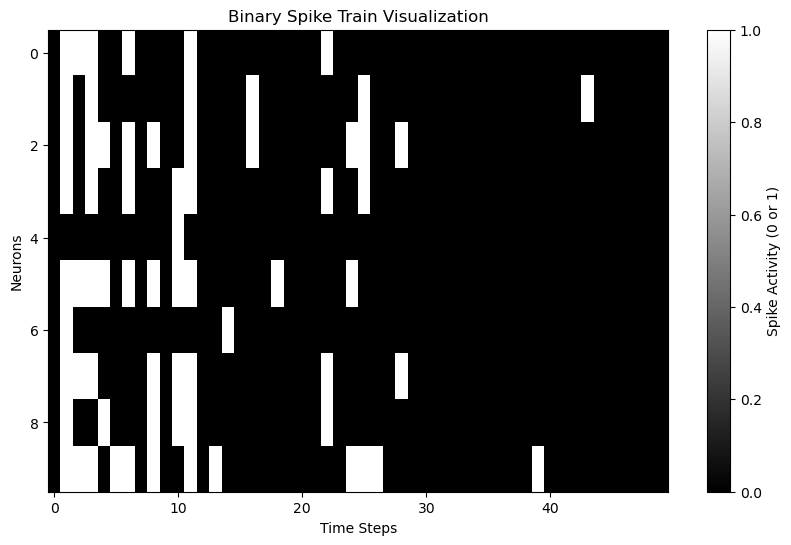

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_spike_train(spike_train, num_neurons=10, num_time_steps=50):
    plt.figure(figsize=(10, 6))
    plt.imshow(spike_train[:num_neurons, :num_time_steps], cmap='gray', aspect='auto')
    plt.colorbar(label='Spike Activity (0 or 1)')
    plt.xlabel('Time Steps')
    plt.ylabel('Neurons')
    plt.title('Binary Spike Train Visualization')
    plt.show()

# Assuming spike_train was generated earlier
visualize_spike_train(spike_train)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [40]:
labels = preprocessor.labels.values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(spike_train, labels, test_size=0.2, random_state=42)

# Check the shapes to ensure compatibility
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (563, 103), X_test shape: (141, 103)
y_train shape: (563,), y_test shape: (141,)


In [44]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


;print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([563, 103]), y_train_tensor shape: torch.Size([563])
X_test_tensor shape: torch.Size([141, 103]), y_test_tensor shape: torch.Size([141])


In [45]:
input_size_dnn = X_train_tensor.shape[1]  # Matches number of features (neurons)
hidden_size_dnn = 128
output_size_dnn = 2  # Binary classification (ASD or not ASD)
num_layers_dnn = 3
learning_rate = 0.001
num_epochs = 30

In [46]:
deep_network = DeepNetwork(input_size_dnn, hidden_size_dnn, output_size_dnn, num_layers_dnn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_network.parameters(), lr=learning_rate)

In [47]:
train_losses = []
train_accuracies = []

In [48]:
for epoch in range(num_epochs):
    # Forward pass
    outputs = deep_network(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    _, predicted = torch.max(outputs.data, 1)
    accuracy = accuracy_score(y_train_tensor, predicted)
    
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/30], Loss: 0.7209, Accuracy: 0.2718
Epoch [2/30], Loss: 0.7114, Accuracy: 0.2718
Epoch [3/30], Loss: 0.7021, Accuracy: 0.2735
Epoch [4/30], Loss: 0.6927, Accuracy: 0.5044
Epoch [5/30], Loss: 0.6831, Accuracy: 0.7318
Epoch [6/30], Loss: 0.6731, Accuracy: 0.7282
Epoch [7/30], Loss: 0.6627, Accuracy: 0.7282
Epoch [8/30], Loss: 0.6517, Accuracy: 0.7282
Epoch [9/30], Loss: 0.6400, Accuracy: 0.7282
Epoch [10/30], Loss: 0.6274, Accuracy: 0.7282
Epoch [11/30], Loss: 0.6136, Accuracy: 0.7282
Epoch [12/30], Loss: 0.5987, Accuracy: 0.7282
Epoch [13/30], Loss: 0.5823, Accuracy: 0.7282
Epoch [14/30], Loss: 0.5643, Accuracy: 0.7282
Epoch [15/30], Loss: 0.5445, Accuracy: 0.7282
Epoch [16/30], Loss: 0.5228, Accuracy: 0.7282
Epoch [17/30], Loss: 0.4991, Accuracy: 0.7282
Epoch [18/30], Loss: 0.4735, Accuracy: 0.7353
Epoch [19/30], Loss: 0.4466, Accuracy: 0.7744
Epoch [20/30], Loss: 0.4186, Accuracy: 0.8099
Epoch [21/30], Loss: 0.3904, Accuracy: 0.8419
Epoch [22/30], Loss: 0.3626, Accuracy: 0.86

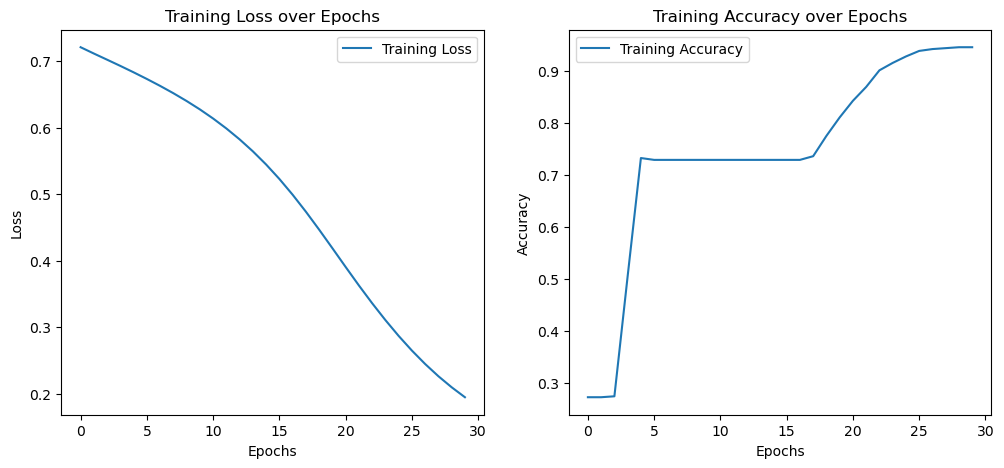

In [49]:
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()

In [50]:
outputs_test = deep_network(X_test_tensor)
_, predicted_test = torch.max(outputs_test.data, 1)
test_accuracy = accuracy_score(y_test_tensor, predicted_test)

print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9362


# Reinforcement Learning

In [51]:
class ReinforcementLearningModuleForDNN:
    def __init__(self, deep_network, learning_rate=0.001, gamma=0.99):
        self.deep_network = deep_network
        self.optimizer = optim.Adam(deep_network.parameters(), lr=learning_rate)
        self.gamma = gamma  # Discount factor for future rewards
        
        # Critic network (for Actor-Critic model)
        self.critic = nn.Linear(deep_network.output_layer.out_features, 1)

    def compute_loss(self, predicted_output, reward):
        critic_value = self.critic(predicted_output)
        td_error = reward - critic_value
        return torch.mean(td_error ** 2)

    def update_policy(self, input_features, reward):
        predicted_output = self.deep_network(input_features)
        loss = self.compute_loss(predicted_output, reward)
        
        # Perform backpropagation and update the network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [52]:
# RL module
rl_module_dnn = ReinforcementLearningModuleForDNN(deep_network, learning_rate=0.001, gamma=0.99)

In [53]:

reward = torch.tensor([1.0])  # Positive reward example on spike output
for i in range(num_epochs):
    # Perform RL updates in environment
    loss_rl = rl_module_dnn.update_policy(X_train_tensor, reward)
    print(f'RL Epoch [{i+1}/{num_epochs}], Loss: {loss_rl:.4f}')

# Evaluate again after RL training
outputs_test_rl = deep_network(X_test_tensor)
_, predicted_test_rl = torch.max(outputs_test_rl.data, 1)
test_accuracy_rl = accuracy_score(y_test_tensor, predicted_test_rl)

print(f'Test Accuracy after RL: {test_accuracy_rl:.4f}')

RL Epoch [1/30], Loss: 1.6310
RL Epoch [2/30], Loss: 1.3287
RL Epoch [3/30], Loss: 1.0224
RL Epoch [4/30], Loss: 0.7269
RL Epoch [5/30], Loss: 0.4752
RL Epoch [6/30], Loss: 0.3009
RL Epoch [7/30], Loss: 0.2261
RL Epoch [8/30], Loss: 0.2453
RL Epoch [9/30], Loss: 0.3039
RL Epoch [10/30], Loss: 0.3357
RL Epoch [11/30], Loss: 0.3165
RL Epoch [12/30], Loss: 0.2599
RL Epoch [13/30], Loss: 0.1910
RL Epoch [14/30], Loss: 0.1309
RL Epoch [15/30], Loss: 0.0906
RL Epoch [16/30], Loss: 0.0720
RL Epoch [17/30], Loss: 0.0706
RL Epoch [18/30], Loss: 0.0790
RL Epoch [19/30], Loss: 0.0898
RL Epoch [20/30], Loss: 0.0975
RL Epoch [21/30], Loss: 0.0991
RL Epoch [22/30], Loss: 0.0937
RL Epoch [23/30], Loss: 0.0826
RL Epoch [24/30], Loss: 0.0681
RL Epoch [25/30], Loss: 0.0532
RL Epoch [26/30], Loss: 0.0412
RL Epoch [27/30], Loss: 0.0341
RL Epoch [28/30], Loss: 0.0330
RL Epoch [29/30], Loss: 0.0366
RL Epoch [30/30], Loss: 0.0422
Test Accuracy after RL: 0.7447


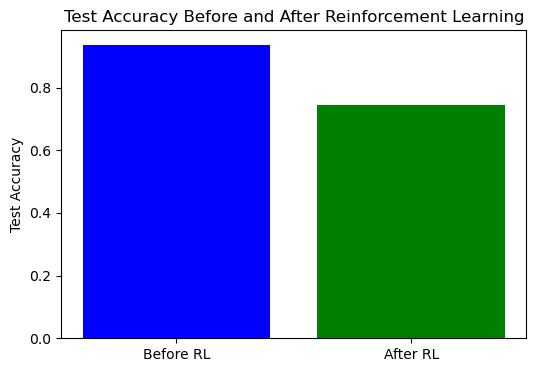

Test Accuracy Improvement: -0.1915


In [54]:
# Plot comparison of test accuracy before and after RL
plt.figure(figsize=(6, 4))
plt.bar(['Before RL', 'After RL'], [test_accuracy, test_accuracy_rl], color=['blue', 'green'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Before and After Reinforcement Learning')
plt.show()

# Display accuracy improvement
print(f"Test Accuracy Improvement: {test_accuracy_rl - test_accuracy:.4f}")